<a href="https://colab.research.google.com/github/mradolovic/istratrack/blob/master/tutorials/01_introduction/tutorial_plot_mesh_1d_dolfinx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot a 1D dolfinx mesh

In [1]:
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ebd1b62/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

--2024-06-04 12:35:44--  https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ebd1b62/releases/fenicsx-install-real.sh
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fem-on-colab/fem-on-colab.github.io/ebd1b62f61aa4c9e0746fabaef18721892c73578/releases/fenicsx-install-real.sh [following]
--2024-06-04 12:35:44--  https://raw.githubusercontent.com/fem-on-colab/fem-on-colab.github.io/ebd1b62f61aa4c9e0746fabaef18721892c73578/releases/fenicsx-install-real.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4.2K) [text/plain]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[==

In [2]:
try:
  import matplotlib
except ImportError:
  !pip install matplotlib
  import matplotlib

trame


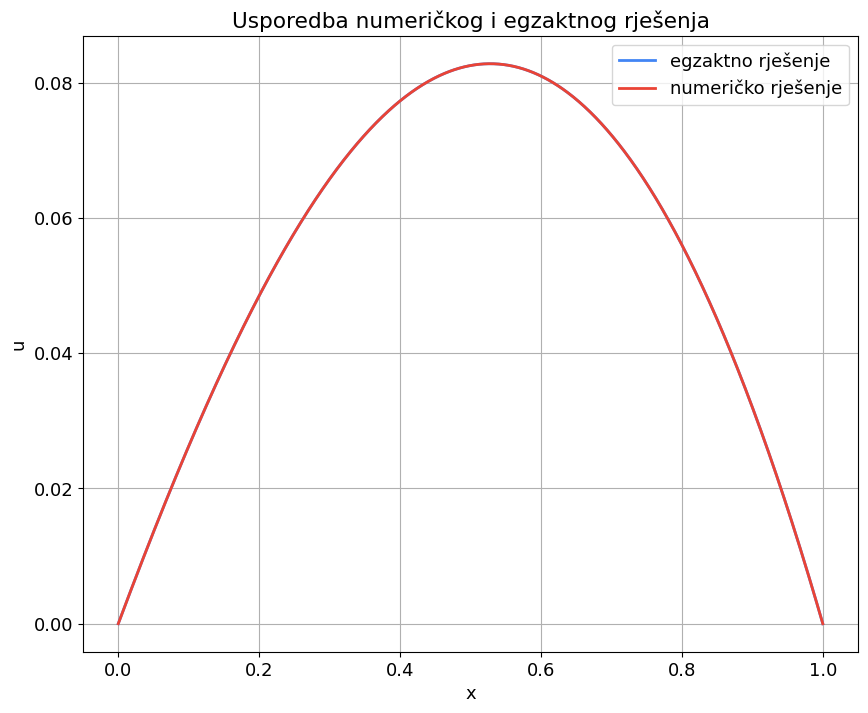

In [9]:
#DOLFINx version: 0.8.0

# FEM za 1D Poissonov problem
#   -u'' = x*(1-x) na intervalu (0,1)
#   u(0) = u(1) = 0
#   egzaktno rješenje u = x^4/12 - x^3/6 + x/12

from dolfinx import mesh, fem, io, plot
from dolfinx.fem.petsc import assemble_matrix, create_vector, assemble_vector, apply_lifting
from petsc4py import PETSc

import ufl

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

mpi_comm = MPI.COMM_WORLD

import pyvista
print(pyvista.global_theme.jupyter_backend)

# Domena i funkcijski prostor
#---------------------------------------------------------
nx = 1000
domena = mesh.create_unit_interval(mpi_comm, nx)
x = ufl.SpatialCoordinate(domena)
V = fem.functionspace(domena, ('Lagrange', 1))

uh = fem.Function(V)


# Rub domene i rubni uvjeti
#---------------------------------------------------------
dim_domena = domena.topology.dim
dim_rub = dim_domena - 1
domena.topology.create_connectivity(dim_rub, dim_domena)

# stupnjevi slobode nisu isto što i čvorovi mesha. To vrijedi samo za P1 elemente
rub_indeks = mesh.exterior_facet_indices(domena.topology)
rub_dofs = fem.locate_dofs_topological(V, dim_rub, rub_indeks)

u_rub = fem.Constant(domena, PETSc.ScalarType(0))
rubni_uvjet = fem.dirichletbc(u_rub, rub_dofs, V)


# Pobuda
#---------------------------------------------------------
f = fem.Function(V)
f.interpolate(lambda x: 2*x[0])


# Slaba formulacija
#---------------------------------------------------------
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)

a = (1+x[0]) * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx


# Asembliranje i rješavanje sustava
#---------------------------------------------------------
problem = fem.petsc.LinearProblem(a, L, bcs=[rubni_uvjet])
uh = problem.solve()


# Stvarno rješenje
#---------------------------------------------------------
n_egz = 1000
domena_egz = mesh.create_unit_interval(mpi_comm, n_egz)
V_egz = fem.functionspace(domena_egz, ('Lagrange', 1))
u_egz = fem.Function(V_egz)
u_egz.interpolate(lambda x: -np.power(x[0],2)/2 + x[0] - np.log(1+x[0])*(1/np.log(4)))


# Graf
#---------------------------------------------------------
cells, types, x = plot.vtk_mesh(V)
cells_egz, types_egz, x_egz = plot.vtk_mesh(V_egz)

'''
u_grid = pyvista.UnstructuredGrid(cells, types, x)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()
'''

plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x_egz[:,0], u_egz.x.array.real, linewidth=2, color = '#4285F4', label = 'egzaktno rješenje')
plt.plot(x[:,0], uh.x.array.real, linewidth=2, color = '#EA4335', label = 'numeričko rješenje')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title('Usporedba numeričkog i egzaktnog rješenja')
plt.grid()
#plt.savefig('./rezultati/poisson1D_rjesenje.png', bbox_inches='tight')
plt.show()
plt.close()